In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [207]:
dtypes = {
    "Cause of Death": "category",
    "Year": int,
    "Month": "category",
    "Age group": "category",
    "Vaccination status": "category",
}

cols = [
    "Cause of Death",
    "Year",
    "Month",
    "Age group",
    "Vaccination status",
    "Count of Deaths",
]

def conv_deaths(n):
    if n == "<3":
        return 2
    return int(n)

In [208]:
df = pd.read_csv(
    "table8.tsv",
    sep="\t",
    skiprows=3,
    header=0,
    dtype=dtypes,
    usecols=cols,
    converters={"Count of Deaths": conv_deaths}
)
df.head(5)

,Cause of Death,Year,Month,Age group,Vaccination status,Count of Deaths
0,All causes,2021,January,10-39,Unvaccinated,969
1,All causes,2021,January,10-39,Ever vaccinated,17
2,All causes,2021,January,40-49,Unvaccinated,1574
3,All causes,2021,January,40-49,Ever vaccinated,24
4,All causes,2021,January,50-59,Unvaccinated,3954


In [209]:
df.columns

Index(['Cause of Death', 'Year', 'Month', 'Age group', 'Vaccination status',
       'Count of Deaths'],
      dtype='object')

In [210]:
df.dtypes

Cause of Death        category
Year                     int64
Month                 category
Age group             category
Vaccination status    category
Count of Deaths          int64
dtype: object

In [230]:
group_cols = [
    "Vaccination status",
    "Year",
    "Month"
]

dfa = (df[df["Cause of Death"] == "Deaths involving COVID-19"]
      .drop(columns="Cause of Death")
      .groupby(group_cols)
      .agg({"Count of Deaths": "sum"})
      .reset_index())

dfa.insert(
    0,
    "Date",
    value=dfa["Month"].astype(str) + " " + dfa["Year"].astype(str)
)
dfa["Date"] = pd.to_datetime(dfa["Date"])

dfa.drop(columns=["Year", "Month"], inplace=True)
dfa.head(5)

,Date,Vaccination status,Count of Deaths
0,2021-04-01,Ever vaccinated,595
1,2021-08-01,Ever vaccinated,1911
2,2021-12-01,Ever vaccinated,2320
3,2021-02-01,Ever vaccinated,5543
4,2021-01-01,Ever vaccinated,3951


In [231]:
dfv = dfa[dfa["Vaccination status"] == "Ever vaccinated"].drop(columns="Vaccination status")
dfu = dfa[dfa["Vaccination status"] != "Ever vaccinated"].drop(columns="Vaccination status")
dfv.head(3)

,Date,Count of Deaths
0,2021-04-01,595
1,2021-08-01,1911
2,2021-12-01,2320


In [232]:
dfm = dfv.merge(
    dfu,
    on=["Date"],
    suffixes=(", Vacc.", ", Unvac.")
)
dfm.head(3)

,Date,"Count of Deaths, Vacc.","Count of Deaths, Unvac."
0,2021-04-01,595,308
1,2021-08-01,1911,849
2,2021-12-01,2320,1017


In [214]:
sns.set()
sns.set_style("whitegrid")

In [217]:
df19 = (
    dfm[(dfm["Date"] >= "2022-01-01") &
        (dfm["Date"] < "2022-06-01")]
        .sort_values("Date")
        .reset_index(drop=True)
)

df19["% of Deaths, Unvac."] = df19["Count of Deaths, Unvac."] * 100 / (df19["Count of Deaths, Unvac."] + df19["Count of Deaths, Vacc."])

df19["% of Deaths, Vacc."] = df19["Count of Deaths, Vacc."] * 100 / (df19["Count of Deaths, Unvac."] + df19["Count of Deaths, Vacc."])

df19

,"Count of Deaths, Vacc.",Date,"Count of Deaths, Unvac.","% of Deaths, Unvac.","% of Deaths, Vacc."
0,4492,2022-01-01,1017,18.460701,81.539299
1,2763,2022-02-01,371,11.837907,88.162093
2,3003,2022-03-01,287,8.723404,91.276596
3,3783,2022-04-01,275,6.776737,93.223263
4,1439,2022-05-01,120,7.697242,92.302758


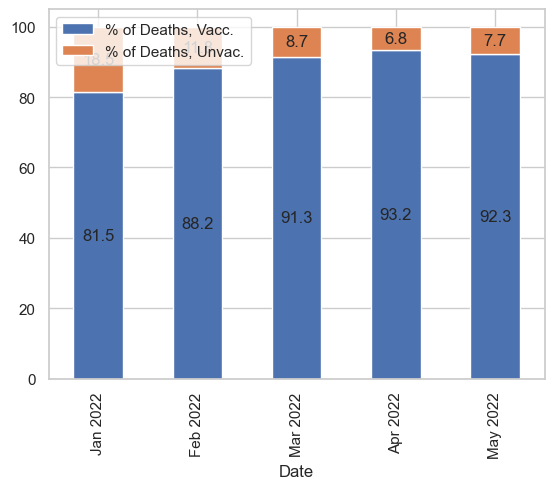

In [216]:
ax = df19.plot.bar(
    x='Date',
    y=["% of Deaths, Vacc.", "% of Deaths, Unvac."],
    stacked=True
)

ax.set_xticklabels(df19["Date"].dt.strftime("%b %Y"))
ax.bar_label(ax.containers[0], label_type="center", fmt="%.1f")
ax.bar_label(ax.containers[1], label_type="center", fmt="%.1f")

plt.show()

In [199]:
import dask.dataframe as dd

ovid_cols = [
    "iso_code",
    "date",
    "people_vaccinated",
    "population",
]

ddf = dd.read_csv(
    "owid-covid-data.csv",
    usecols=ovid_cols,
    parse_dates=["date"],
)

owid = ddf[
    (ddf["iso_code"] == "GBR") &
    (ddf["date"].dt.day == 1)].compute()

owid.drop("iso_code", axis=1, inplace=True)
owid["perc_vacc"] = owid["people_vaccinated"] * 100 / owid["population"]
owid["perc_unvac"] = 100 - owid["perc_vacc"]

owid.dtypes

date                 datetime64[ns]
people_vaccinated           float64
population                  float64
perc_vacc                   float64
perc_unvac                  float64
dtype: object

In [200]:
owid.head(3)

,date,people_vaccinated,population,perc_vacc,perc_unvac
200555,2020-02-01,NaN,67281040.0,NaN,NaN
200584,2020-03-01,NaN,67281040.0,NaN,NaN
200615,2020-04-01,NaN,67281040.0,NaN,NaN


In [201]:
owid.tail(3)

,date,people_vaccinated,population,perc_vacc,perc_unvac
201436,2022-07-01,53617742.0,67281040.0,79.692202,20.307798
201467,2022-08-01,53726268.0,67281040.0,79.853504,20.146496
201498,2022-09-01,NaN,67281040.0,NaN,NaN


In [202]:
pdata2 = owid[
    (owid["date"] >= "2022-01-01") &
    (owid["date"] < "2022-06-01")].sort_values("date").reset_index(drop=True)

pdata2

,date,people_vaccinated,population,perc_vacc,perc_unvac
0,2022-01-01,51789045.0,67281040.0,76.974204,23.025796
1,2022-02-01,52373222.0,67281040.0,77.842468,22.157532
2,2022-03-01,52640258.0,67281040.0,78.239364,21.760636
3,2022-04-01,52808470.0,67281040.0,78.489378,21.510622
4,2022-05-01,53242209.0,67281040.0,79.134046,20.865954


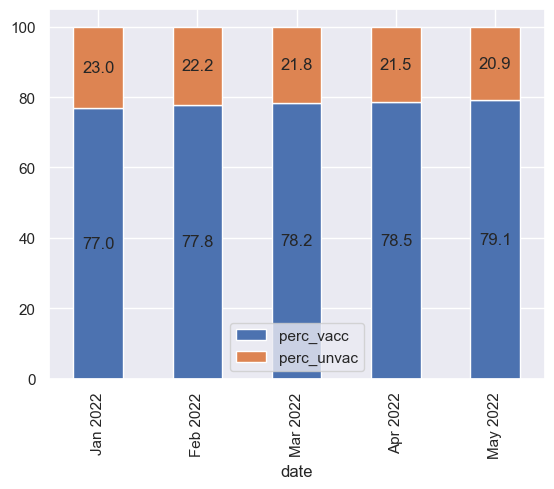

In [203]:
ax2 = pdata2.plot.bar(
    x="date",
    y=["perc_vacc", "perc_unvac"],
    stacked=True
)

ax2.set_xticklabels(pdata2["date"].dt.strftime("%b %Y"))
ax2.bar_label(ax2.containers[0], label_type="center", fmt="%.1f")
ax2.bar_label(ax2.containers[1], label_type="center", fmt="%.1f")

plt.show()

In [226]:
dfr = df19[["Date", "Count of Deaths, Vacc.", "Count of Deaths, Unvac."]].merge(
    pdata2[["date", "people_vaccinated", "population"]],
    left_on="Date",
    right_on="date",
).drop(columns="date")

dfr.columns = ["date", "deaths_vacc", "deaths_unvac", "people_vacc", "population"]
dfr["deaths_per100k_vacc"] = dfr["deaths_vacc"] * 100000 / dfr["people_vacc"]
dfr["deaths_per100k_unvac"] = dfr["deaths_unvac"] * 100000 / (dfr["population"] - dfr["people_vacc"])

dfr[["date", "deaths_per100k_vacc", "deaths_per100k_unvac"]]

,date,deaths_per100k_vacc,deaths_per100k_unvac
0,2022-01-01,8.673649,6.564681
1,2022-02-01,5.275597,2.488627
2,2022-03-01,5.704759,1.960278
3,2022-04-01,7.163624,1.900146
4,2022-05-01,2.702743,0.854772


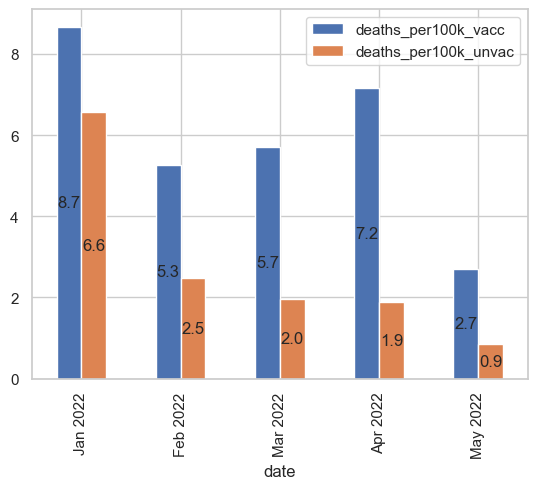

In [227]:
ax3 = dfr.plot.bar(
    x="date",
    y=["deaths_per100k_vacc", "deaths_per100k_unvac"],
)

ax3.set_xticklabels(dfr["date"].dt.strftime("%b %Y"))
ax3.bar_label(ax3.containers[0], label_type="center", fmt="%.1f")
ax3.bar_label(ax3.containers[1], label_type="center", fmt="%.1f")

plt.show()